<a href="https://colab.research.google.com/github/Shoab02/Healthcheck/blob/main/models/heart_pred_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install xgboost
!pip install lgb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement lgb (from versions: none)
ERROR: No matching distribution found for lgb


In [2]:
!pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 254 kB 15.8 MB/s 
     |████████████████████████████████| 829 kB 41.1 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 182 kB 60.3 MB/s 
     |████████████████████████████████| 132 kB 68.5 MB/s 
     |████████████████████████████████| 9.8 MB 50.3 MB/s 
     |████████████████████████████████| 79 kB 5.5 MB/s 
     |████████████████████████████████| 140 kB 57.3 MB/s 
     |████████████████████████████████| 67 kB 3.4 MB/s 
     |████████████████████████████████| 130 kB 46.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 127 kB 54.1 MB/s 
     |████████████████████████████████| 66 kB 3.3 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.16.11-py2.py3-none-any.whl size=426888 sha256=18dda3a499405ee713a9d6f0208dab5cbf9aea19010109a37

In [3]:
#Importing machine learning algorithms
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
 
#Importing other packages
import timeit
import pandas as pd
import numpy as np
import neptune.new as neptune
 
#Importing packages for machine learning operations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

In [20]:
run = neptune.init(
    project="shoab02/Heart-Prediction",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlNjI3ODIyYi02NDBiLTRiN2ItOGIyMi1lZWY5MDMxOGQ3YzQifQ==",
)


https://app.neptune.ai/shoab02/Heart-Prediction/e/HEARTPRED-3
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Datasets/heart.csv')

Mounted at /content/drive


In [6]:
def description(data):
  print(f'Dataset shape: {df.shape}')
  summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
  summary = summary.reset_index()
  summary['Name'] =  summary['index']
  summary['Missing'] = df.isna().sum().values
  summary['% Missing'] = df.isna().sum().values/df.isna().count().values
  summary['Uniques'] = df.nunique().values

  return summary[['Name','Missing','% Missing', 'Uniques','dtypes' ]]

description(df)

Dataset shape: (303, 14)


,Name,Missing,% Missing,Uniques,dtypes
0,age,0,0.0,41,int64
1,sex,0,0.0,2,int64
2,cp,0,0.0,4,int64
3,trtbps,0,0.0,49,int64
4,chol,0,0.0,152,int64
5,fbs,0,0.0,2,int64
6,restecg,0,0.0,3,int64
7,thalachh,0,0.0,91,int64
8,exng,0,0.0,2,int64
9,oldpeak,0,0.0,40,float64


In [7]:
X = df.drop('output',axis=1)
y = df['output']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=22)

In [9]:


def model_tuner(model, X, y, param_grid):

  grid = GridSearchCV(model, param_grid, n_jobs=-1, verbose=1)

  grid.fit(X, y)

  return grid.best_params_



In [28]:
def metrics(run, y_pred, y_test):
   score = roc_auc_score(y_test, y_pred)
   run['ROC AUC score'] = score
   return score

def run_model(run, model, description, X, y):

  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=22)

  run['Description'] = description

  #Training
  start = timeit.default_timer()
  model.fit(X_train, y_train)
  stop = timeit.default_timer()
  run['Training time'] = stop - start

  #Prediction
  start = timeit.default_timer()
  y_pred = model.predict(X_test)
  stop = timeit.default_timer()
  run['Training time'] = stop - start

  return y_test,y_pred


In [10]:
cbc = cb.CatBoostClassifier()
xgbc = xgb.XGBClassifier()
lgbc = lgb.LGBMClassifier()

estimators=[cbc, xgbc, lgbc]

In [11]:
cbc_params={
    'n_estimators':[100,300,500],
    'learning_rate': [0.01, 0.1,1],
    'depth': [4, 6, 10],
    'subsample':[0.6,0.8,1],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

xgbc_params={
    'learning_rate':[0.001, 0.01, 0.1, 1],
    'max_depth': [6, 8, 12, 32],
    'subsample':[0.6,0.8,1],
    'colsample_bytree': [0.5,0.7,1],
    'gamma': [0,0.2,0.5],
    'reg_alpha':[0,0.01,0.1],
    'reg_lambda':[0,0.01,0.1]
}

lgbc_params={
    'max_depth': [3, 6, 8, 12],
    'num_leaves': [2**i for i in [3,6,8,12]],
    'min_data_in_leaf':[100,300,1000]
}

In [12]:

best_params_cbc = model_tuner(cbc, X, y, cbc_params)
best_params_cbc

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
0:	learn: 0.6858571	total: 46.9ms	remaining: 14s
1:	learn: 0.6808443	total: 48.6ms	remaining: 7.25s
2:	learn: 0.6755387	total: 49.6ms	remaining: 4.91s
3:	learn: 0.6691332	total: 50.6ms	remaining: 3.74s
4:	learn: 0.6636939	total: 51.5ms	remaining: 3.04s
5:	learn: 0.6573987	total: 52.4ms	remaining: 2.56s
6:	learn: 0.6526413	total: 53.2ms	remaining: 2.23s
7:	learn: 0.6452945	total: 54.1ms	remaining: 1.97s
8:	learn: 0.6393815	total: 55ms	remaining: 1.78s
9:	learn: 0.6328054	total: 55.8ms	remaining: 1.62s
10:	learn: 0.6270964	total: 56.7ms	remaining: 1.49s
11:	learn: 0.6219343	total: 57.5ms	remaining: 1.38s
12:	learn: 0.6150980	total: 58.4ms	remaining: 1.29s
13:	learn: 0.6107516	total: 59.3ms	remaining: 1.21s
14:	learn: 0.6050868	total: 60.3ms	remaining: 1.15s
15:	learn: 0.6007486	total: 61.2ms	remaining: 1.09s
16:	learn: 0.5966782	total: 62.1ms	remaining: 1.03s
17:	learn: 0.5921267	total: 63ms	remaining: 987ms
18:	learn: 0.587

{'depth': 4,
 'l2_leaf_reg': 5,
 'learning_rate': 0.01,
 'n_estimators': 300,
 'subsample': 0.6}

In [13]:
best_params_xgbc = model_tuner(xgbc, X, y, xgbc_params)
best_params_xgbc

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


{'colsample_bytree': 0.5,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 8,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.6}

In [14]:
best_params_lgbc = model_tuner(lgbc, X, y, lgbc_params)
best_params_lgbc

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_depth': 3, 'min_data_in_leaf': 100, 'num_leaves': 8}

In [29]:
xgbc = xgb.XGBClassifier(
    colsample_bytree= 0.5,
    gamma= 0,
    learning_rate= 0.01,
    max_depth= 8,
    reg_alpha= 0,
    reg_lambda= 0,
    subsample= 0.6
)

y_test, y_pred = run_model(run = run, model =xgbc, description = "XGBoost Model with best params",X = X, y = y)

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        27
           1       0.81      0.85      0.83        34

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



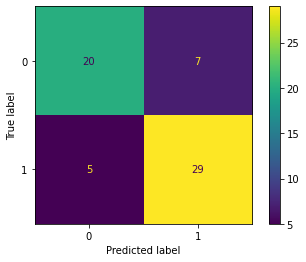

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


score = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

In [37]:
cbc = cb.CatBoostClassifier(
    depth= 4,
    l2_leaf_reg= 5,
    learning_rate= 0.01,
    n_estimators= 300,
    subsample= 0.6
)

y_test, y_pred = run_model(run = run, model =cbc, description = "Catboost Model with best params",X = X, y = y)

0:	learn: 0.6870170	total: 956us	remaining: 286ms
1:	learn: 0.6822758	total: 2.15ms	remaining: 320ms
2:	learn: 0.6775605	total: 2.94ms	remaining: 291ms
3:	learn: 0.6725262	total: 3.75ms	remaining: 278ms
4:	learn: 0.6660602	total: 4.52ms	remaining: 267ms
5:	learn: 0.6587389	total: 5.25ms	remaining: 257ms
6:	learn: 0.6511446	total: 5.98ms	remaining: 250ms
7:	learn: 0.6446217	total: 6.84ms	remaining: 250ms
8:	learn: 0.6404569	total: 7.57ms	remaining: 245ms
9:	learn: 0.6340781	total: 8.34ms	remaining: 242ms
10:	learn: 0.6299677	total: 9.11ms	remaining: 239ms
11:	learn: 0.6249636	total: 9.98ms	remaining: 240ms
12:	learn: 0.6201663	total: 10.8ms	remaining: 238ms
13:	learn: 0.6151261	total: 11.6ms	remaining: 236ms
14:	learn: 0.6096028	total: 12.3ms	remaining: 234ms
15:	learn: 0.6029016	total: 13ms	remaining: 232ms
16:	learn: 0.5968074	total: 13.8ms	remaining: 229ms
17:	learn: 0.5933299	total: 14.5ms	remaining: 228ms
18:	learn: 0.5876003	total: 15.3ms	remaining: 226ms
19:	learn: 0.5826640	tota

Accuracy score:  0.7868852459016393
              precision    recall  f1-score   support

           0       0.82      0.67      0.73        27
           1       0.77      0.88      0.82        34

    accuracy                           0.79        61
   macro avg       0.79      0.77      0.78        61
weighted avg       0.79      0.79      0.78        61



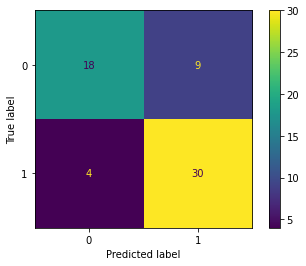

In [39]:
print('Accuracy score: ',accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()



In [45]:
lgbc = lgb.LGBMClassifier(max_depth= 3, min_data_in_leaf= 100, num_leaves= 8)
                          
y_test, y_pred = run_model(run = run, model =lgbc, description = "LGB Model with best params",X = X, y = y)                          

Accuracy score:  0.7704918032786885
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        27
           1       0.78      0.82      0.80        34

    accuracy                           0.77        61
   macro avg       0.77      0.76      0.77        61
weighted avg       0.77      0.77      0.77        61



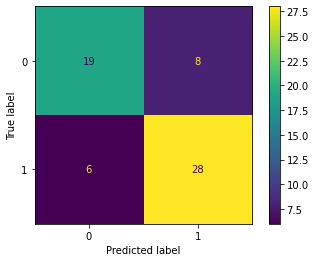

In [46]:
print('Accuracy score: ',accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()


In [48]:
xgbc.save_model('heart_pred.model')